In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

import time
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import callbacks
from keras import losses
from tensorflow.keras.models import save_model, load_model

2025-11-21 10:39:04.653227: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 10:39:04.688835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


%pip install seaborn

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Dataset loading and visualization

In [3]:
colonne=pd.read_csv('./kddcup.names',sep=':',skiprows=1,header=None)

attacchi=pd.DataFrame(['attack_type'])

hn=pd.concat([colonne,attacchi],ignore_index=True)
header_names=hn.iloc[:,0].tolist()

print(header_names,'\n')

data = pd.read_csv('./data_no_dup.csv',names=header_names)

label=data['attack_type']
data=data.drop(['attack_type'],axis=1)


['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'] 



In [4]:
#print(data.describe,'\n')
#print(label.shape,'\n')
#print(label.describe,'\n')

In [5]:
col_names = np.array(header_names)
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

#print('Nominal: ',nominal_idx)
#for j in nominal_idx: print(header_names[j])
#print()

#print('Binary: ', binary_idx)
#for j in binary_idx: print(header_names[j])
#print()

#print('Numeric: ',numeric_idx)
#for j in numeric_idx: print(header_names[j])

nominal_column=col_names[nominal_idx].tolist()
binary_column=col_names[binary_idx].tolist()
numeric_column=col_names[numeric_idx].tolist()

#print('\nNumeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

attack_type
normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64


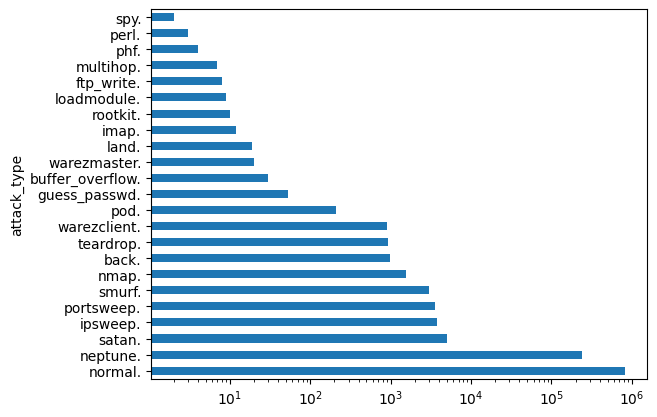

In [6]:
from collections import defaultdict
category = defaultdict(list)
category['benign'].append('normal.')
with open('./training_attack_types.txt', 'r') as ff:
    for line in ff.readlines():
        attack_name, attack_cat = line.strip().split(' ')
        category[attack_cat].append(attack_name)

#print(category)

attack_mapping = dict((a,c) for c in category for a in category[c])
#print('\nAttack mapping: ',attack_mapping,'\n')

attacchi=label.value_counts()
print(attacchi)
attacchi.plot(kind='barh')
plt.xscale('log')

attack_type
benign    812814
dos       247267
probe      13860
r2l          999
u2r           52
Name: count, dtype: int64


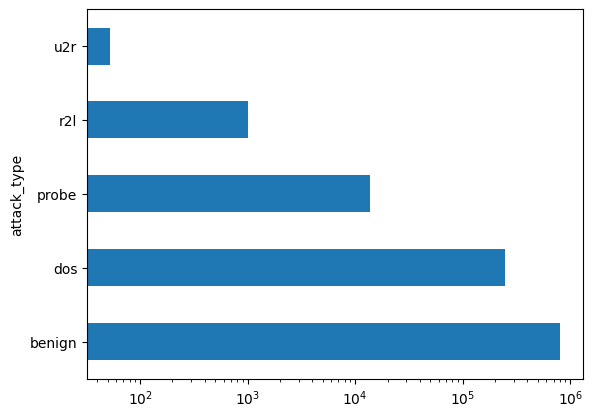

In [7]:
label_cat=label.map(lambda x: attack_mapping[x])
categorie_attacchi=label_cat.value_counts()
print(categorie_attacchi)
categorie_attacchi.plot(kind='barh')
plt.xscale('log')

# Data analysis and fixing

In [8]:
#data[binary_column].describe().transpose()


In [9]:
#data[nominal_column].describe().transpose()

In [10]:
#data['protocol_type'].unique()

In [11]:
#data[numeric_column].describe().transpose()

In [12]:
# In the category 'su_attempted' the maximum is 2 altough it is binary, we have to fix it
#data.groupby(['su_attempted']).size()


In [13]:
data.groupby(['su_attempted']).size()

su_attempted
0    1074882
1         40
2         70
dtype: int64

In [14]:
#data['su_attempted'].replace(2,1,inplace=True)
data['su_attempted']=data['su_attempted'].replace(2,1)
data.groupby(['su_attempted']).size()

su_attempted
0    1074882
1        110
dtype: int64

In [15]:
# In the category 'su_attempted' the maximum count is 0, thus we can safely remove it
#data.groupby(['num_outbound_cmds']).size()


In [16]:
data.drop('num_outbound_cmds', axis=1, inplace=True)
ind=numeric_column.index('num_outbound_cmds')
numeric_column.remove('num_outbound_cmds')
numeric_idx.remove(ind)

In [17]:
print('Numeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

Numeric:  31 
Binary:  6 
Nominal:  3


# Data preparation

In [18]:
data_raw = pd.get_dummies(data, columns=nominal_column, drop_first=True)


In [19]:
data.shape

(1074992, 40)

In [20]:
data_raw.shape

(1074992, 118)

In [21]:
dummy_variables = list(set(data_raw) - set(data))
#print(dummy_variables)

# Create a classification dataset

In [22]:
#label_cat_bin = label_cat.apply(lambda x: 'benign' if x == 'benign' else 'attack')

In [23]:
#np.array(X_train_t)
#np.array(X_train_t)

In [24]:
#ca=label_cat_bin.value_counts()
#print(ca,'\n')
ca_train=label_cat.value_counts()
#ca_test=y_test.value_counts()
print('Training:\n',ca_train)#,'\n\nTest: \n',ca_test)

Training:
 attack_type
benign    812814
dos       247267
probe      13860
r2l          999
u2r           52
Name: count, dtype: int64


In [25]:
# split dataset -> train + test dataset
label_cat_dummies=pd.get_dummies(label_cat, drop_first=False)
label_cat_num=np.array(label_cat_dummies)

#data_raw_numpy=np.array(data_raw)

print(label_cat_num.shape,'\n')
#print(label_cat_num[1:15],'\n')
label_ann=list(label_cat_dummies)
print(label_ann,'\n')

X_train, X_test, y_train, y_test = train_test_split(data_raw, label_cat_num, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,X_train.shape[0]+X_test.shape[0],len(data_raw))

(1074992, 5) 

['benign', 'dos', 'probe', 'r2l', 'u2r'] 

(859993, 118) (214999, 118) 1074992 1074992


In [26]:
X_train.shape

(859993, 118)

In [27]:
X_test.shape

(214999, 118)

In [28]:
y_train.shape

(859993, 5)

In [29]:
y_test.shape

(214999, 5)

In [30]:
# split train -> train_t + validation dataset
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Regularization of numeric features

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#train_data_std = X_train
#test_data_std = X_test

scaler = MinMaxScaler().fit(X_train_t[numeric_column])

#train_data_std.loc[:,numeric_column] = standard_scaler.transform(train_data_std[numeric_column])
#test_data_std.loc[:,numeric_column] = standard_scaler.transform(test_data_std[numeric_column])

X_train_t = X_train_t.copy()
X_train_t[numeric_column] = X_train_t[numeric_column].astype(float)
X_train_t.loc[:, numeric_column] = scaler.transform(X_train_t[numeric_column])

# Old style, with warnings
#X_train_t[numeric_column] = scaler.transform(X_train_t[numeric_column])
#X_test[numeric_column] = scaler.transform(X_test[numeric_column])
#X_val[numeric_column] = scaler.transform(X_val[numeric_column])

X_val = X_val.copy()
X_val[numeric_column] = X_val[numeric_column].astype(float)
X_val.loc[:, numeric_column] = scaler.transform(X_val[numeric_column])


X_test = X_test.copy()
X_test[numeric_column] = X_test[numeric_column].astype(float)
X_test.loc[:, numeric_column] = scaler.transform(X_test[numeric_column])


In [32]:
X_train_t[binary_column].describe().transpose()


count      mean       std  min  25%  50%  75%  max
land            687994.0  0.000020  0.004511  0.0  0.0  0.0  0.0  1.0
logged_in       687994.0  0.629405  0.482964  0.0  0.0  1.0  1.0  1.0
root_shell      687994.0  0.000285  0.016876  0.0  0.0  0.0  0.0  1.0
su_attempted    687994.0  0.000106  0.010300  0.0  0.0  0.0  0.0  1.0
is_host_login   687994.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
is_guest_login  687994.0  0.003817  0.061663  0.0  0.0  0.0  0.0  1.0

In [33]:
X_train_t[dummy_variables].describe().transpose()

count unique    top    freq
service_ftp        687994      2  False  684687
service_ssh        687994      2  False  687315
flag_SH            687994      2  False  687786
service_http_2784  687994      1  False  687994
service_auth       687994      2  False  685865
...                   ...    ...    ...     ...
service_telnet     687994      2  False  685263
service_imap4      687994      2  False  687355
service_Z39_50     687994      2  False  687325
service_tim_i      687994      2  False  687986
flag_SF            687994      2   True  503108

[81 rows x 4 columns]

In [34]:
X_train_t[numeric_column].describe().transpose()

count      mean       std  min       25%  \
duration                     687994.0  0.002286  0.022336  0.0  0.000000   
src_bytes                    687994.0  0.000006  0.001794  0.0  0.000000   
dst_bytes                    687994.0  0.000010  0.001707  0.0  0.000000   
wrong_fragment               687994.0  0.000885  0.029010  0.0  0.000000   
urgent                       687994.0  0.000003  0.001277  0.0  0.000000   
hot                          687994.0  0.000716  0.013165  0.0  0.000000   
num_failed_logins            687994.0  0.000036  0.003716  0.0  0.000000   
num_compromised              687994.0  0.000006  0.001333  0.0  0.000000   
num_root                     687994.0  0.000009  0.001355  0.0  0.000000   
num_file_creations           687994.0  0.000126  0.006135  0.0  0.000000   
num_shells                   687994.0  0.000176  0.009568  0.0  0.000000   
num_access_files             687994.0  0.000489  0.008275  0.0  0.000000   
count                        687994.0  0.096845  0.166968  0.0  0.003914   
srv_count                    687994.0  0.025398  0.057427  0.0  0.003914   
serror_rate                  687994.0  0.190715  0.391456  0.0  0.000000   
srv_serror_rate              687994.0  0.191458  0.392191  0.0  0.000000   
rerror_rate                  687994.0  0.078225  0.267082  0.0  0.000000   
srv_rerror_rate              687994.0  0.077998  0.266011  0.0  0.000000   
same_srv_rate                687994.0  0.777921  0.392152  0.0  0.990000   
diff_srv_rate                687994.0  0.031616  0.116878  0.0  0.000000   
srv_diff_host_rate           687994.0  0.117816  0.265498  0.0  0.000000   
dst_host_count               687994.0  0.635328  0.401053  0.0  0.196078   
dst_host_srv_count           687994.0  0.623823  0.431018  0.0  0.070588   
dst_host_same_srv_rate       687994.0  0.669608  0.426122  0.0  0.070000   
dst_host_diff_srv_rate       687994.0  0.049419  0.130799  0.0  0.000000   
dst_host_same_src_port_rate  687994.0  0.093464  0.230040  0.0  0.000000   
dst_host_srv_diff_host_rate  687994.0  0.021750  0.056337  0.0  0.000000   
dst_host_serror_rate         687994.0  0.191273  0.391236  0.0  0.000000   
dst_host_srv_serror_rate     687994.0  0.190760  0.391846  0.0  0.000000   
dst_host_rerror_rate         687994.0  0.079666  0.262445  0.0  0.000000   
dst_host_srv_rerror_rate     687994.0  0.078312  0.261098  0.0  0.000000   

                                      50%           75%  max  
duration                     0.000000e+00  0.000000e+00  1.0  
src_bytes                    3.144039e-07  4.413192e-07  1.0  
dst_bytes                    8.293965e-07  4.299372e-06  1.0  
wrong_fragment               0.000000e+00  0.000000e+00  1.0  
urgent                       0.000000e+00  0.000000e+00  1.0  
hot                          0.000000e+00  0.000000e+00  1.0  
num_failed_logins            0.000000e+00  0.000000e+00  1.0  
num_compromised              0.000000e+00  0.000000e+00  1.0  
num_root                     0.000000e+00  0.000000e+00  1.0  
num_file_creations           0.000000e+00  0.000000e+00  1.0  
num_shells                   0.000000e+00  0.000000e+00  1.0  
num_access_files             0.000000e+00  0.000000e+00  1.0  
count                        1.565558e-02  6.653620e-02  1.0  
srv_count                    1.369863e-02  2.935421e-02  1.0  
serror_rate                  0.000000e+00  0.000000e+00  1.0  
srv_serror_rate              0.000000e+00  0.000000e+00  1.0  
rerror_rate                  0.000000e+00  0.000000e+00  1.0  
srv_rerror_rate              0.000000e+00  0.000000e+00  1.0  
same_srv_rate                1.000000e+00  1.000000e+00  1.0  
diff_srv_rate                0.000000e+00  1.000000e-02  1.0  
srv_diff_host_rate           0.000000e+00  9.000000e-02  1.0  
dst_host_count               8.784314e-01  1.000000e+00  1.0  
dst_host_srv_count           9.725490e-01  1.000000e+00  1.0  
dst_host_same_srv_rate       1.000000e+00  1.000000e+00  1.0  
dst_host_diff_srv_rate  

In [35]:
X_test[numeric_column].describe().transpose()

count          mean       std  min       25%  \
duration                     214999.0  2.351735e-03  0.023165  0.0  0.000000   
src_bytes                    214999.0  1.190920e-05  0.004302  0.0  0.000000   
dst_bytes                    214999.0  7.473876e-06  0.000122  0.0  0.000000   
wrong_fragment               214999.0  9.162833e-04  0.029478  0.0  0.000000   
urgent                       214999.0  9.966824e-07  0.000344  0.0  0.000000   
hot                          214999.0  6.784689e-04  0.012479  0.0  0.000000   
num_failed_logins            214999.0  3.720948e-05  0.004762  0.0  0.000000   
num_compromised              214999.0  3.008127e-06  0.000373  0.0  0.000000   
num_root                     214999.0  6.009545e-06  0.000418  0.0  0.000000   
num_file_creations           214999.0  1.344517e-04  0.006684  0.0  0.000000   
num_shells                   214999.0  1.651170e-04  0.009085  0.0  0.000000   
num_access_files             214999.0  4.692528e-04  0.007905  0.0  0.000000   
count                        214999.0  9.662849e-02  0.167137  0.0  0.003914   
srv_count                    214999.0  2.533811e-02  0.057593  0.0  0.003914   
serror_rate                  214999.0  1.896025e-01  0.390538  0.0  0.000000   
srv_serror_rate              214999.0  1.901929e-01  0.391169  0.0  0.000000   
rerror_rate                  214999.0  7.876353e-02  0.267961  0.0  0.000000   
srv_rerror_rate              214999.0  7.858906e-02  0.266995  0.0  0.000000   
same_srv_rate                214999.0  7.785404e-01  0.391683  0.0  1.000000   
diff_srv_rate                214999.0  3.170029e-02  0.117212  0.0  0.000000   
srv_diff_host_rate           214999.0  1.178375e-01  0.265424  0.0  0.000000   
dst_host_count               214999.0  6.353121e-01  0.400858  0.0  0.200000   
dst_host_srv_count           214999.0  6.237850e-01  0.431034  0.0  0.070588   
dst_host_same_srv_rate       214999.0  6.694876e-01  0.426052  0.0  0.070000   
dst_host_diff_srv_rate       214999.0  4.982921e-02  0.131777  0.0  0.000000   
dst_host_same_src_port_rate  214999.0  9.315076e-02  0.229472  0.0  0.000000   
dst_host_srv_diff_host_rate  214999.0  2.170401e-02  0.056832  0.0  0.000000   
dst_host_serror_rate         214999.0  1.901351e-01  0.390385  0.0  0.000000   
dst_host_srv_serror_rate     214999.0  1.896244e-01  0.390948  0.0  0.000000   
dst_host_rerror_rate         214999.0  7.992967e-02  0.262737  0.0  0.000000   
dst_host_srv_rerror_rate     214999.0  7.888730e-02  0.261826  0.0  0.000000   

                                      50%           75%       max  
duration                     0.000000e+00  0.000000e+00  0.732843  
src_bytes                    3.144039e-07  4.413192e-07  1.990211  
dst_bytes                    8.293965e-07  4.294375e-06  0.029305  
wrong_fragment               0.000000e+00  0.000000e+00  1.000000  
urgent                       0.000000e+00  0.000000e+00  0.142857  
hot                          0.000000e+00  0.000000e+00  0.389610  
num_failed_logins            0.000000e+00  0.000000e+00  1.250000  
num_compromised              0.000000e+00  0.000000e+00  0.083166  
num_root                     0.000000e+00  0.000000e+00  0.091591  
num_file_creations           0.000000e+00  0.000000e+00  0.930233  
num_shells                   0.000000e+00  0.000000e+00  0.500000  
num_access_files             0.000000e+00  0.000000e+00  0.555556  
count                        1.565558e-02  6.653620e-02  1.000000  
srv_count                    1.369863e-02  2.935421e-02  1.000000  
serror_rate                  0.000000e+00  0.000000e+00  1.000000  
srv_serror_rate              0.000000e+00  0.000000e+00  1.000000  
rerror_rate                  0.000000e+00  0.000000e+00  1.000000  
srv_rerror_rate              0.000000e+00  0.000000e+00  1.000000  
same_srv_rate                1.000000e+00  1.000000e+00  1.000000  
diff_srv_rate                0.000000e+00  1.000000e-02  1.000000  
srv_diff_host_rate           0.000000e+00  

In [36]:
print(X_train_t.shape,X_val.shape,X_train.shape)

(687994, 118) (171999, 118) (859993, 118)


In [37]:
X_train_t=np.array(X_train_t)
X_test=np.array(X_test)
X_val=np.array(X_val)

X_train_t = np.nan_to_num(X_train_t, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

In [38]:
X_train_t = X_train_t.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train_t = y_train_t.astype(np.float32)
y_val = y_val.astype(np.float32)

In [39]:
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
X_test = X_test.astype(np.float32)

## Define and run the DNN

In [40]:
n_features = X_train_t.shape[1]

total_sum=np.sum(y_train_t)
cat_attack=np.sum(y_train_t,axis=0)
print(total_sum, cat_attack[0], cat_attack[1], cat_attack[2], cat_attack[3], cat_attack[4],'\n')

687994.0 519793.0 158708.0 8821.0 641.0 31.0 



In [41]:
# ANN model

class_weight_KDD = {0: 1,
                1: cat_attack[0]/cat_attack[1],
                2: cat_attack[0]/cat_attack[2],
                3: cat_attack[0]/cat_attack[3],
                4: cat_attack[0]/cat_attack[4]}

ann = models.Sequential()
ann.add(keras.Input(shape=(n_features,)))
ann.add(layer=layers.Dense(units=60, activation='relu'))
#ann.add(layer=layers.Dense(units=60, activation='relu', input_shape=[n_features]))
ann.add(layers.Dropout(0.2))
ann.add(layer=layers.Dense(units=60, activation='relu'))
ann.add(layers.Dropout(0.2))
ann.add(layer=layers.Dense(units=5, activation='softmax'))

ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = ann.fit(x=X_train_t, y=y_train_t, epochs=100, verbose=1, validation_data=(X_val, y_val), class_weight=class_weight_KDD, callbacks=[es])

Epoch 1/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.9544 - loss: 2.5421 - val_accuracy: 0.9614 - val_loss: 0.0847
Epoch 2/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9662 - loss: 2.4772 - val_accuracy: 0.9693 - val_loss: 0.0770
Epoch 3/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9691 - loss: 2.5470 - val_accuracy: 0.9691 - val_loss: 0.0816
Epoch 4/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9736 - loss: 2.0873 - val_accuracy: 0.9913 - val_loss: 0.0345
Epoch 5/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9688 - loss: 2.6977 - val_accuracy: 0.9631 - val_loss: 0.1146
Epoch 6/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9696 - loss: 2.8466 - val_accuracy: 0.9849 - val_loss: 0.0687
Epoch 7/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9714 - loss: 2.1256 - val_accuracy: 0.9652 - val_loss: 0.0841
Epoch 8/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - ac

![1_wDGvx0z0-nEB8zQHykvwPw.webp](attachment:2af06f5d-40bf-42bb-a8d6-6f2898462a2c.webp)

![1_DNewrtjKh8F2uK0TwE8C4A.webp](attachment:6bb48dec-5e02-43b8-bd9a-1b70140bfc4c.webp)

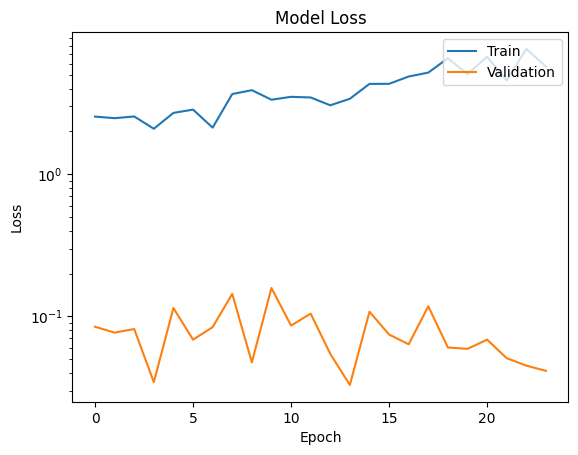

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [43]:

ann.summary()
models.save_model(ann, './model_ann_2025.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         7,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

In [44]:
#ann=models.load_model('/content/drive/MyDrive/Colab Notebooks/model_ann_2023')
#ann.summary()

In [45]:
# Build Confusion Matrix
samples = X_test.shape[0]
t_0=time.monotonic()
y_predicted = ann.predict(x=X_test)
t_1=time.monotonic()
y_pred_classes = np.argmax(y_predicted,axis = 1)
y_true = np.argmax(y_test,axis = 1)

print('\nTime per instance: ',(t_1-t_0)/samples*1000,' ms')


6719/6719 ━━━━━━━━━━━━━━━━━━━━ 7s 973us/step

Time per instance:  0.04050048752175577  ms


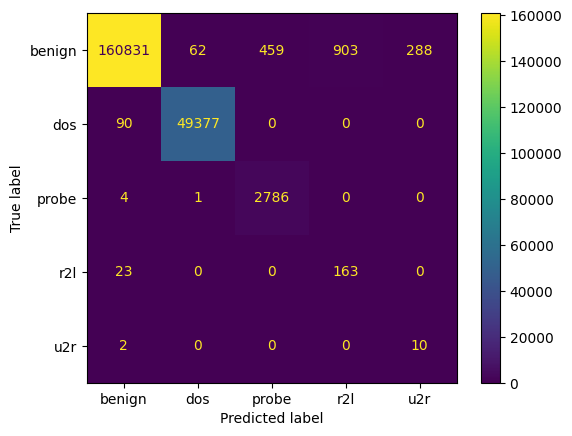

In [46]:
results_ann = confusion_matrix(y_true, y_pred_classes)
error_ann = zero_one_loss(y_true, y_pred_classes)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=results_ann, display_labels=label_ann)
disp_ann.plot()
plt.show()

In [47]:
precision_score(y_true,y_pred_classes,average=None)

array([0.99926064, 0.99872573, 0.85855162, 0.15290807, 0.03355705])

In [48]:
recall_score(y_true,y_pred_classes,average=None)

array([0.9894674 , 0.99818061, 0.99820853, 0.87634409, 0.83333333])

In [49]:
f1_score(y_true,y_pred_classes,average=None)

array([0.99433991, 0.99845309, 0.9231279 , 0.26038339, 0.06451613])

In [50]:
# Binary random forest

In [51]:
y_train_t_bin = np.argmax(y_train_t,axis = 1)
y_test_bin = np.argmax(y_test,axis = 1)
y_val_bin = np.argmax(y_val,axis = 1)

for x in np.arange(0,len(y_train_t_bin)): y_train_t_bin[x]=min(y_train_t_bin[x],1)
for x in np.arange(0,len(y_test_bin)): y_test_bin[x]=min(y_test_bin[x],1)
for x in np.arange(0,len(y_val_bin)): y_val_bin[x]=min(y_val_bin[x],1)



Training:  51.27453361079097 seconds
Classification:  1.3167971558868885 seconds
Classification time per instance  6.1246664211781844e-06
[[162534      9]
 [    35  52421]] 
Error:  0.00020465211466103028


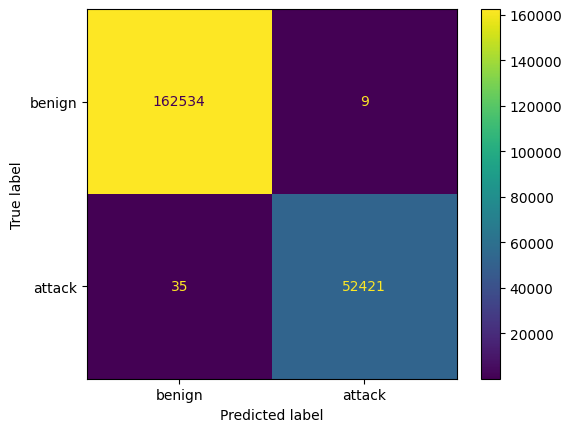

In [52]:
from sklearn.ensemble import RandomForestClassifier

t0 = time.monotonic()
#classifier_rf = RandomForestClassifier(criterion='entropy', random_state=10)
classifier_rf_bin = RandomForestClassifier(n_estimators=101, criterion='entropy', random_state=42)
classifier_rf_bin.fit(X_train_t,y_train_t_bin)
t1 = time.monotonic()
pred_label_cat_rf_bin = classifier_rf_bin.predict(X_test)
t2 = time.monotonic()

results_rf_bin = confusion_matrix(y_test_bin, pred_label_cat_rf_bin)
error_rf_bin = zero_one_loss(y_test_bin, pred_label_cat_rf_bin)

print('\nTraining: ',(t1-t0),'seconds\nClassification: ',(t2-t1),'seconds\nClassification time per instance ', (t2-t1)/len(y_test_bin))
print(results_rf_bin,'\nError: ',error_rf_bin)

label_bin=['benign','attack']
disp_rf_bin = ConfusionMatrixDisplay(confusion_matrix=results_rf_bin, display_labels=label_bin)
disp_rf_bin.plot()
plt.show()

In [54]:
ann_bin = models.Sequential()
ann_bin.add(keras.Input(shape=(X_train_t.shape[1],)))
ann_bin.add(layer=layers.Dense(units=30, activation='relu'))
ann_bin.add(layers.Dropout(0.2))
ann_bin.add(layer=layers.Dense(units=5, activation='relu'))
ann_bin.add(layers.Dropout(0.1))
ann_bin.add(layer=layers.Dense(units=1, activation='sigmoid'))

ann_bin.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_bin = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history_bin = ann_bin.fit(x=X_train_t, y=y_train_t_bin, epochs=100, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[es_bin])

Epoch 1/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9961 - loss: 0.0176 - val_accuracy: 0.9978 - val_loss: 0.0080
Epoch 2/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9976 - loss: 0.0087 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 3/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 4/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 0.9989 - val_loss: 0.0038
Epoch 5/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9989 - val_loss: 0.0041
Epoch 6/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9990 - val_loss: 0.0037
Epoch 7/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9990 - val_loss: 0.0037
Epoch 8/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - ac

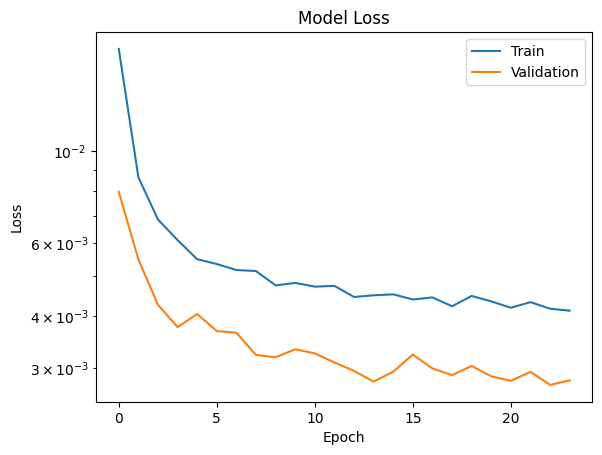

In [55]:
plt.plot(history_bin.history['loss'])
plt.plot(history_bin.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [56]:
ann_bin.summary()
models.save_model(ann_bin, './model_ann_bin_10_2025.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 30)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,195 (43.73 KB)

 Trainable params: 3,731 (14.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,464 (29.16 KB)

In [57]:
#ann_bin=models.load_model('/model_ann_bin_10_2023.keras')
#ann_bin.summary()

In [58]:
samples = X_test.shape[0]
t_0=time.monotonic()
y_predicted_bin = ann_bin.predict(x=X_test)
t_1=time.monotonic()
y_pred_classes_bin = (y_predicted_bin > 0.5)


print('\nTime per instance: ',(t_1-t_0)/samples*1000,' ms')

6719/6719 ━━━━━━━━━━━━━━━━━━━━ 4s 654us/step

Time per instance:  0.028528393580337246  ms


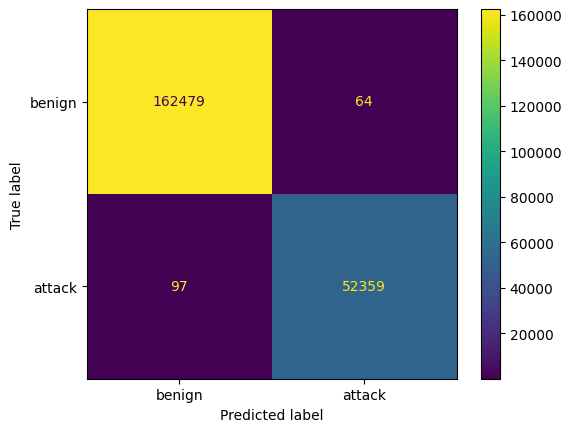

In [59]:
results_ann_bin = confusion_matrix(y_test_bin, y_pred_classes_bin)
error_ann_bin = zero_one_loss(y_test_bin, y_pred_classes_bin)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=results_ann_bin, display_labels=label_bin)
disp_ann.plot()
plt.show()

In [60]:
new_train_attack = np.c_[X_train_t, y_train_t]
print(new_train_attack.shape)
new_val_attack = np.c_[X_val, y_val]
print(new_val_attack.shape)

(687994, 123)
(171999, 123)


In [61]:
new_train_attack = np.delete(new_train_attack, np.where(new_train_attack[:,X_train_t.shape[1]]==1), axis=0)
print(new_train_attack.shape)
new_val_attack = np.delete(new_val_attack, np.where(new_val_attack[:,X_val.shape[1]]==1), axis=0)
print(new_val_attack.shape)

(168201, 123)
(41521, 123)


In [62]:
# Drop real 'benign' traffic from X_train_t and X_val dataset
label_attack=new_train_attack[:,slice(X_train_t.shape[1],new_train_attack.shape[1])]
print(label_attack.shape)
new_train_attack=np.delete(new_train_attack,slice(X_train_t.shape[1], X_train_t.shape[1]+label_attack.shape[1]),axis=1)
print(new_train_attack.shape)

label_attack_val=new_val_attack[:,slice(X_val.shape[1],new_val_attack.shape[1])]
print(label_attack_val.shape)
new_val_attack=np.delete(new_val_attack,slice(X_val.shape[1], X_val.shape[1]+label_attack_val.shape[1]),axis=1)
print(new_val_attack.shape)

(168201, 5)
(168201, 118)
(41521, 5)
(41521, 118)


In [63]:
# Drop traffic estimated as 'benign' from RF binary classifier in the test dataset
new_test_attack=np.c_[X_test, pred_label_cat_rf_bin, y_test]
print(new_test_attack.shape)
new_test_attack=np.delete(new_test_attack,  np.where(new_test_attack[:,X_test.shape[1]]==0), axis=0  )
y_test_numeric=new_test_attack[:,slice(new_test_attack.shape[1]-y_test.shape[1], new_test_attack.shape[1])]
new_test_attack=np.delete(new_test_attack, slice(X_test.shape[1],new_test_attack.shape[1]), axis=1)
print(new_test_attack.shape)
print(y_test_numeric.shape)

(214999, 124)
(52430, 118)
(52430, 5)


In [64]:
n_features = new_train_attack.shape[1]

total_sum=np.sum(label_attack)
cat_attack=np.sum(label_attack,axis=0)
print(total_sum, cat_attack[0], cat_attack[1], cat_attack[2], cat_attack[3], cat_attack[4],'\n')

168201.0 0.0 158708.0 8821.0 641.0 31.0 



In [65]:
label_attack_ann = label_attack[:,1:5]
label_attack_ann.shape

label_attack_val_ann = label_attack_val[:,1:5]
label_attack_val_ann.shape

(41521, 4)

In [66]:
class_weight_KDD_attack = {0: 1,
                1: cat_attack[1]/cat_attack[2],
                2: cat_attack[1]/cat_attack[3],
                3: cat_attack[1]/cat_attack[4]}

ann_attack = models.Sequential()
ann_attack.add(keras.Input(shape=(n_features,)))
ann_attack.add(layer=layers.Dense(units=20, activation='relu'))
ann_attack.add(layers.Dropout(0.2))
ann_attack.add(layer=layers.Dense(units=20, activation='relu'))
ann_attack.add(layers.Dropout(0.2))
ann_attack.add(layer=layers.Dense(units=4, activation='softmax'))

ann_attack.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es_attack = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = ann_attack.fit(x=new_train_attack, y=label_attack_ann, epochs=100, verbose=1, validation_data=(new_val_attack, label_attack_val_ann), class_weight=class_weight_KDD_attack, callbacks=[es_attack])

Epoch 1/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9793 - loss: 2.2593 - val_accuracy: 0.9987 - val_loss: 0.0067
Epoch 2/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9952 - loss: 1.2223 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 3/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9958 - loss: 0.8333 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 4/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9960 - loss: 0.9351 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 5/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9961 - loss: 0.9064 - val_accuracy: 0.9991 - val_loss: 0.0037
Epoch 6/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9966 - loss: 0.6720 - val_accuracy: 0.9996 - val_loss: 0.0024
Epoch 7/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9968 - loss: 0.8048 - val_accuracy: 0.9995 - val_loss: 0.0029
Epoch 8/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9969 -

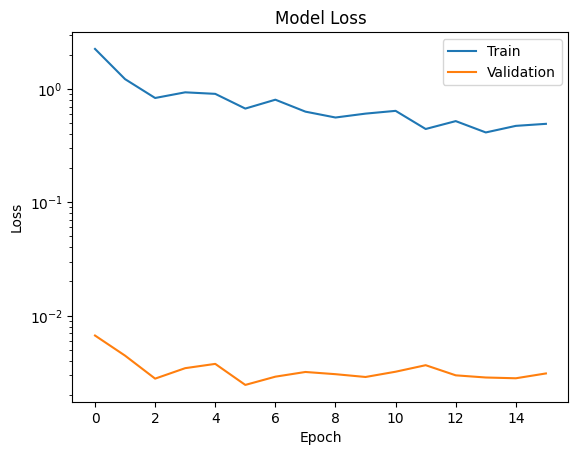

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [68]:
ann_attack.summary()
models.save_model(ann_attack, './model_ann_hier_2025.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 20)             │         2,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,654 (33.81 KB)

 Trainable params: 2,884 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,770 (22.54 KB)

In [69]:
#ann_attack=models.load_model('/content/drive/MyDrive/Colab Notebooks/model_ann_hier_2023')
#ann_attack.summary()

In [70]:
# Build Confusion Matrix
samples_h = new_test_attack.shape[0]
t_0=time.monotonic()
y_predicted_h = ann_attack.predict(x=new_test_attack)
t_1=time.monotonic()
y_pred_classes_h = np.argmax(y_predicted_h,axis = 1)+1
y_true_h = np.argmax(y_test_numeric,axis = 1)

print('\nTime per instance: ',(t_1-t_0)/samples_h*1000,' ms')

1639/1639 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step

Time per instance:  0.04210112807906676  ms


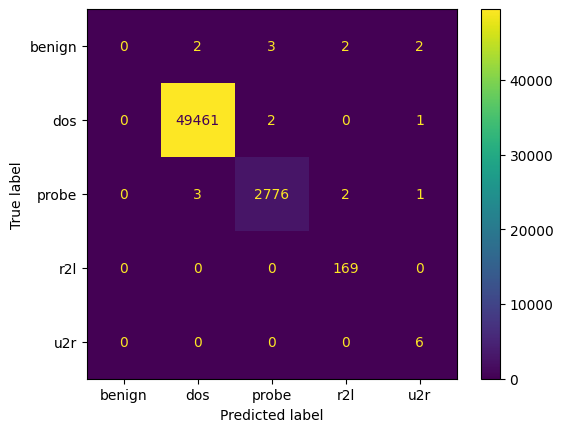

In [71]:
results_ann_h = confusion_matrix(y_true_h, y_pred_classes_h)
error_ann_h = zero_one_loss(y_true_h, y_pred_classes_h)

disp_ann_h = ConfusionMatrixDisplay(confusion_matrix=results_ann_h, display_labels=label_ann)
disp_ann_h.plot()
plt.show()

In [72]:
ann_attack2 = models.Sequential()
ann_attack2.add(keras.Input(shape=(n_features,)))
ann_attack2.add(layer=layers.Dense(units=20, activation='relu'))
ann_attack2.add(layers.Dropout(0.2))
ann_attack2.add(layer=layers.Dense(units=20, activation='relu'))
ann_attack2.add(layers.Dropout(0.2))
ann_attack2.add(layer=layers.Dense(units=4, activation='softmax'))

ann_attack2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es_attack2 = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history2 = ann_attack2.fit(x=new_train_attack, y=label_attack_ann, epochs=100, verbose=1, validation_data=(new_val_attack, label_attack_val_ann),  callbacks=[es_attack])

Epoch 1/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9932 - loss: 0.0263 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 2/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9996 - val_loss: 0.0025
Epoch 3/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 4/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9997 - val_loss: 0.0023
Epoch 5/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9997 - val_loss: 0.0026
Epoch 6/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9996 - val_loss: 0.0029
Epoch 7/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9996 - val_loss: 0.0028
Epoch 8/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9997 -

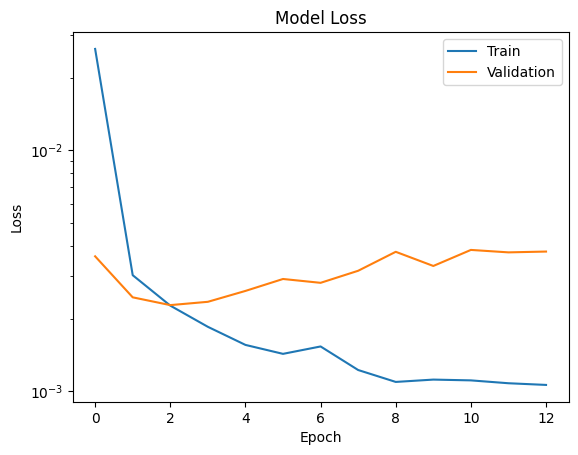

In [73]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [74]:
ann_attack2.summary()
models.save_model(ann_attack2, './model_ann_hier_2025_no_weights.keras')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 20)             │         2,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,654 (33.81 KB)

 Trainable params: 2,884 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,770 (22.54 KB)

In [75]:
# Build Confusion Matrix
samples_h = new_test_attack.shape[0]
t_0=time.monotonic()
y_predicted_h2 = ann_attack2.predict(x=new_test_attack)
t_1=time.monotonic()
y_pred_classes_h2 = np.argmax(y_predicted_h2,axis = 1)+1
y_true_h = np.argmax(y_test_numeric,axis = 1)

print('\nTime per instance: ',(t_1-t_0)/samples_h*1000,' ms')

1639/1639 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Time per instance:  0.04531284273750746  ms


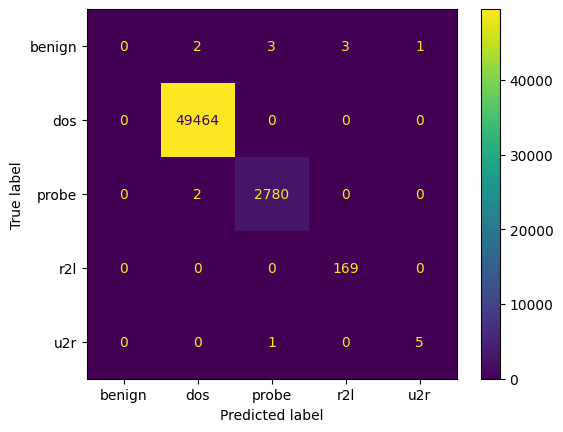

In [76]:
results_ann_h2 = confusion_matrix(y_true_h, y_pred_classes_h2)
error_ann_h2 = zero_one_loss(y_true_h, y_pred_classes_h2)

disp_ann_h2 = ConfusionMatrixDisplay(confusion_matrix=results_ann_h2, display_labels=label_ann)
disp_ann_h2.plot()
plt.show()